In [0]:

import os
import sys
import librosa
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import pickle
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

from itertools import chain
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

from sklearn.metrics import recall_score,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import GRU, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/EE599 Final Project/final dataset/data_combined.csv',encoding='utf-8')
test_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/EE599 Final Project/final dataset/testing_data_3.csv',encoding='utf-8')


In [4]:
data

X = data.iloc[:,1:-1]
y = data['Label']
X

x_test = test_data.iloc[:,1:-1]
y_test = test_data['Label']

test_data


,Name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,text,words_count,noun_freq,verb_freq,adjective_freq,adverb_freq,Label
0,dia0_utt0.mp3,-352.847230,121.015248,-14.527324,14.125641,-14.020860,5.341154,-12.629353,-5.395495,-13.576809,-11.516812,-7.851610,4.724108,-9.763668,1.475494,-4.801957,0.858676,-7.443775,-4.622409,-7.551417,-4.162367,-7.317542,-0.495181,-5.281505,-3.080994,-4.586307,-1.282533,-4.348640,0.207438,-0.878259,2.934153,-1.024561,1.715051,-0.408794,3.060293,1.812697,2.356631,-1.373783,0.377254,-2.002667,...,0.000200,0.000213,0.000166,0.000162,0.000348,0.000193,0.000176,0.000175,0.000194,0.000128,0.000172,0.000077,0.000049,0.000048,0.000039,0.000027,0.000021,0.000017,0.000006,4.380000e-07,18.425841,15.062490,17.402848,15.631939,16.740558,17.206656,33.045751,-0.006822,-0.006087,0.043981,-0.039448,-0.000242,0.002305,Why do all youre coffee mugs have numbers on ...,5,0.666667,0.000000,0.000000,0.0,0
1,dia0_utt1.mp3,-342.173040,87.203097,-32.661778,16.109090,-15.958594,-2.311523,-12.116084,-2.631662,-9.685679,4.839020,-12.786594,1.247238,-11.057635,0.565992,-2.867309,-3.594613,-4.907335,-3.785351,-5.986928,-3.690339,-4.032539,-1.886870,-5.303846,-1.372830,-2.040867,0.732936,-0.424088,4.070237,1.206451,6.098135,1.296045,4.654348,0.546106,0.204046,-4.659502,-0.740560,-2.165028,0.435965,-2.183636,...,0.001180,0.001544,0.001823,0.001600,0.002235,0.001512,0.001008,0.000846,0.000963,0.000942,0.000863,0.000630,0.000494,0.000305,0.000244,0.000182,0.000149,0.000090,0.000030,2.030000e-06,14.224542,16.407779,18.892892,18.010093,18.348537,19.530672,34.869454,-0.003380,-0.001250,-0.000798,0.004915,0.002242,0.000521,Oh. Thats so Monica can keep track. That way ...,10,0.272727,0.090909,0.000000,0.0,1
2,dia0_utt2.mp3,-362.927491,112.528435,-7.877308,22.242228,-11.401592,4.034038,-9.438521,2.434923,-5.027654,0.462079,-6.030224,1.669935,-8.438696,-1.618324,-8.217463,-4.668929,-7.900016,-3.886683,-5.209033,-7.147430,-11.590658,-3.313086,-8.007236,-4.034153,-9.712629,-3.721231,-3.984328,7.513057,2.369954,5.147645,-1.870706,-3.827336,-7.406459,0.140606,-2.623259,0.039479,-2.414285,-1.208602,-4.839823,...,0.000047,0.000051,0.000042,0.000039,0.000070,0.000082,0.000073,0.000040,0.000023,0.000019,0.000021,0.000020,0.000017,0.000011,0.000010,0.000011,0.000014,0.000012,0.000004,2.830000e-07,17.731637,16.940625,16.401410,16.397150,16.150507,16.552198,32.318264,-0.019917,-0.009774,0.081948,-0.029796,-0.003427,-0.017818,Y'know what?,0,0.000000,0.000000,0.000000,0.0,2
3,dia100_utt0.mp3,-298.204423,97.688888,-39.464460,23.281199,-19.077867,3.713634,-6.268458,0.173581,-13.445312,6.140498,-5.953345,3.728337,-9.579415,0.378333,-1.065117,3.235801,-3.761408,2.221472,-4.156855,-0.001728,1.160368,8.821804,1.834773,3.634073,-2.392280,-0.813175,-2.074975,2.231445,-3.572630,0.324511,-3.711270,-0.389861,-5.293983,-2.420927,-1.680547,1.735901,-3.268899,-0.049835,-2.266700,...,0.001195,0.001986,0.001242,0.000968,0.000557,0.000492,0.000778,0.000584,0.001015,0.000681,0.000690,0.000711,0.000299,0.000118,0.000130,0.000066,0.000047,0.000020,0.000007,5.510000e-07,14.095936,16.836626,19.372216,17.899932,19.226419,19.873867,39.464127,0.004058,-0.006257,0.024170,0.003161,-0.013062,0.004476,"Me taking care of you is no problem, huh?",5,0.500000,0.000000,0.000000,0.0,2
4,dia100_utt1.mp3,-357.434918,72.865840,-20.977707,22.088450,-13.571144,7.637375,-15.330419,12.083425,-3.779123,3.691567,-7.442588,9.010142,-5.671923,3.706214,2.372784,5.259303,1.078772,6.696903,0.847004,5.164449,-0.757694,0.033082,-4.803117,0.163649,-0.476879,3.575810,-1.274792,1.683424,-2.701994,-1.269879,-6.474667,-2.070633,-3.125841,-0.570343,-4.302230,0.518745,-1.368030,2.619352,-0.339916,...,0.001311,0.001422,0.001488,0.000973,0.000990,0.000686,0.000694,0.000598,0.000683,0.000522,0.000316,0.000267,0.00016

In [0]:
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)



In [6]:

MAX_SEQUENCE_LENGTH = 40
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

embeddings_index = {}

with open("/content/gdrive/My Drive/Colab Notebooks/EE599 Final Project/final dataset/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [7]:

x_train_text = x_train.iloc[:,193:]
x_val_text = x_val.iloc[:,193:]
x_test_text = x_test.iloc[:,193:]
x_test_text 





,text,words_count,noun_freq,verb_freq,adjective_freq,adverb_freq
0,Why do all youre coffee mugs have numbers on ...,5,0.666667,0.000000,0.000000,0.0
1,Oh. Thats so Monica can keep track. That way ...,10,0.272727,0.090909,0.000000,0.0
2,Y'know what?,0,0.000000,0.000000,0.000000,0.0
3,"Me taking care of you is no problem, huh?",5,0.500000,0.000000,0.000000,0.0
4,You guys feel safe.,4,0.000000,0.200000,0.200000,0.0
...,...,...,...,...,...,...
2605,"Hey buddy, do you think I can borrow your unif...",6,0.000000,0.285714,0.142857,0.0
2606,Excuse me?,1,0.500000,0.000000,0.000000,0.0
2607,Joey! Hes working! You would look,5,0.000000,0.166667,0.000000,0.0
2608,"Oh, how bad is it?",2,0.000000,0.000000,0.333333,0.0


In [8]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)   # get the frequently occuring words
tokenizer.fit_on_texts(x_train_text.Text)           
train_sequences = tokenizer.texts_to_sequences(x_train_text.Text)
val_sequences = tokenizer.texts_to_sequences(x_val_text.Text)
test_sequences = tokenizer.texts_to_sequences(x_test_text.text)

word_index = tokenizer.word_index               # dictionary containing words and their index
print(tokenizer.word_index)                   # print to check
print('Found %s unique tokens.' % len(word_index)) # total words in the corpus
train_text = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_text = pad_sequences(val_sequences, maxlen = MAX_SEQUENCE_LENGTH)# get only the top frequent words on train
test_text = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)   # get only the top frequent words on test


scaleable_cols = ['words_count', 'adjective_freq', 'noun_freq', 'adverb_freq', 'verb_freq']

scaler_multicol = MinMaxScaler()
train_multicol_scaled = scaler_multicol.fit_transform(x_train_text[scaleable_cols])
val_multicol_scaled = scaler_multicol.fit_transform(x_val_text[scaleable_cols])
test_multicol_scaled = scaler_multicol.fit_transform(x_test_text[scaleable_cols])

x_train_text = np.hstack((train_text, train_multicol_scaled))
x_val_text = np.hstack((val_text, val_multicol_scaled))
x_test_text= np.hstack((test_text, test_multicol_scaled))


num_words = min(MAX_NUM_WORDS, len(embeddings_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(x_train_text[1])

{'i': 1, 'you': 2, 'the': 3, 'to': 4, 'a': 5, 'and': 6, 'oh': 7, 'it': 8, 'that': 9, 'no': 10, 'what': 11, 'is': 12, 'me': 13, 'this': 14, 'so': 15, 'just': 16, 'of': 17, 'yeah': 18, 'okay': 19, 'my': 20, 'in': 21, 'have': 22, 'we': 23, 'do': 24, 'hey': 25, 'well': 26, 'i\x92m': 27, 'know': 28, 'on': 29, 'all': 30, 'for': 31, 'are': 32, 'with': 33, 'not': 34, 'right': 35, 'was': 36, 'be': 37, 'but': 38, 'your': 39, 'go': 40, 'like': 41, 'here': 42, 'gonna': 43, 'get': 44, 'don\x92t': 45, 'it\x92s': 46, 'out': 47, 'really': 48, 'about': 49, 'uh': 50, 'he': 51, 'can': 52, "i'm": 53, 'up': 54, 'think': 55, 'her': 56, 'look': 57, 'now': 58, 'if': 59, 'at': 60, 'there': 61, 'one': 62, 'how': 63, 'that\x92s': 64, 'got': 65, 'see': 66, 'mean': 67, 'you\x92re': 68, 'him': 69, 'come': 70, 'why': 71, 'god': 72, "it's": 73, 'did': 74, 'ross': 75, 'sorry': 76, 'good': 77, 'she': 78, 'want': 79, 'joey': 80, 'tell': 81, 'they': 82, 'great': 83, 'guys': 84, 'when': 85, "don't": 86, 'y\x92know': 87, "

In [9]:

x_train_audio = x_train.iloc[:,:193]
x_val_audio = x_val.iloc[:,:193]
x_test_audio = x_test.iloc[:,:193]


print(x_train_audio.shape)
print(x_val_audio.shape)
print(x_test_audio.shape)
print(y_train.shape)
x_train_audio


(7990, 193)
(1998, 193)
(2610, 193)
(7990,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
356,-309.413705,104.704924,-7.240125,6.566454,-25.636207,-0.216536,-10.001936,2.743474,-13.992755,3.923538,-13.313784,-2.397028,-4.877463,3.266807,1.965457,0.358135,-8.522909,0.939141,-3.546169,-2.836574,-6.372927,-3.857745,1.507168,6.287444,-8.594585,-1.816416,-2.538505,0.248079,-5.496070,-2.477093,-3.108584,1.419723,-1.859767,-0.923328,-4.613071,2.988839,-2.877976,0.224467,-2.983323,2.520388,...,0.004999,0.003720,0.002751,0.003774,0.004209,0.007236,0.003882,0.004004,0.002763,0.002066,0.002573,0.002762,0.004669,0.010221,0.001711,0.001522,0.005907,0.001467,0.000924,0.000471,0.000395,0.000169,0.000198,0.000108,1.093060e-04,2.370000e-05,4.460000e-06,15.644495,13.180245,19.304979,19.133675,19.054906,18.463550,34.934976,0.005687,0.005619,-0.024218,-0.004962,-0.002335,0.012053
49,-254.080877,100.417461,-44.308427,15.928512,-20.648279,1.011197,-8.643705,-2.575637,-10.655586,12.581487,-4.612838,4.395221,-8.848466,0.292635,-6.821006,-1.804594,-8.983366,4.563537,0.061360,5.566060,1.214010,0.866424,-4.728134,-1.442650,-4.707355,0.187171,-5.502022,-1.798797,-5.181160,-2.083275,-5.942137,-1.034168,-4.861230,0.215322,-2.605351,1.551676,-1.715150,2.337599,-2.891567,1.491064,...,0.001573,0.001524,0.001443,0.001252,0.002314,0.000917,0.000664,0.000542,0.000815,0.000730,0.001580,0.001375,0.000598,0.000498,0.000494,0.000680,0.000465,0.000273,0.000253,0.000207,0.000104,0.000084,0.000073,0.000045,3.310000e-05,1.200000e-05,6.130000e-07,16.328419,12.221172,15.778364,16.006657,16.554507,18.689193,35.261489,-0.008051,-0.002702,-0.001780,0.002556,-0.000648,0.001116
9769,-272.078373,89.976061,-19.240327,24.257199,-10.452452,8.256940,-9.337089,-19.028725,-25.553259,-3.715759,-8.724599,10.829061,-4.377099,-6.139133,-7.466329,-2.459657,-19.038684,-5.344498,3.365879,1.768904,-1.262835,9.616356,-1.019440,0.797989,-3.005468,-1.200362,-3.892587,2.000492,-3.557626,3.012927,-2.350299,4.480146,-1.318352,-1.725609,-2.092129,1.676971,-3.204988,1.247644,-1.880516,0.814961,...,0.006727,0.005756,0.004255,0.002623,0.002928,0.002995,0.002217,0.001972,0.002637,0.001910,0.002083,0.001953,0.001736,0.001579,0.001530,0.001162,0.000696,0.000318,0.000348,0.000361,0.000281,0.000277,0.000277,0.000143,1.038510e-04,3.630000e-05,2.030000e-06,16.682942,15.970742,19.966094,19.714817,21.302937,21.065509,34.114649,0.007327,0.003269,0.007399,0.022335,0.000808,-0.002393
1523,-379.986135,126.768807,-22.815432,17.411884,-26.526822,13.170443,-0.445758,12.878890,-4.987226,4.537793,-4.769606,4.272606,-7.851967,5.127400,-0.958738,-3.468259,-6.686857,5.100084,-6.382981,2.394105,1.762077,3.292161,0.021188,7.536592,0.116692,1.185652,-0.774650,0.428283,-1.015885,-0.199337,0.422927,3.618216,-2.035319,2.049152,-3.061757,0.749255,-2.042194,-1.747326,-3.416035,-0.682392,...,0.000273,0.000137,0.000091,0.000105,0.000126,0.000183,0.000259,0.000240,0.000121,0.000122,0.000045,0.000029,0.000040,0.000023,0.000017,0.000016,0.000017,0.000013,0.000010,0.000008,0.000005,0.000005,0.000003,0.000001,8.990000e-07,2.790000e-07,2.550000e-08,14.773766,13.723273,16.152551,16.612653,16.123487,17.480468,37.428958,-0.001378,0.004212,0.012718,0.002625,-0.007053,0.007120
7539,-348.655418,111.594957,-41.635056,17.322230,-27.724211,-6.726570,-8.858383,-14.158749,-8.861168,14.574281,-9.141687,2.518384,-12.302373,6.041092,-1.437299,0.314071,0.482413,2.050902,0.561103,1.801946,1.185595,4.440683,-1.438446,5.185491,-3.857334,1.709060,0.079976,2.676564,0.704923,3.040317,-0.364144,2.769414,0.960773,3.497960,-0.179849,2.830715,-2.536413,1.289081,-2.687518,1.378182,...,0.000202,0.000138,0.000073,0.000048,0.000031,0.000034,0.000059,0.000083,0.000167,0.000259,0.000193,0.000355,0.000131,0.000072,0.000083,0.000073,0.000058,0.000039,0.000018,0.000016,0.000014,0.000014,0.

In [10]:


posts_input = Input(shape=(None,), dtype='int32', name='Text_input')
embedded_posts = Embedding(input_dim=MAX_NUM_WORDS,
                            input_length=MAX_SEQUENCE_LENGTH, 
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)(posts_input)

x = layers.GRU(128, activation='relu', return_sequences = True)(embedded_posts)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.GRU(64, activation = 'relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
text_model =Model([posts_input], [x])

text_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Text_input (InputLayer)      [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
gru (GRU)                    (None, None, 128)         88320     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128)         512       
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080  

In [0]:
import numpy as np
import os
import sys
import librosa
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout, Flatten, Embedding
import pickle
from xgboost import XGBClassifier

In [0]:

input1 = Input(shape=(193), name='Audio_input') 
layer = layers.Dense(400,activation ='relu')(input1)
layer = layers.Dropout(0.2)(layer)
layer = layers.Dense(300,activation ='relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer = layers.Dense(200,activation ='relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer = layers.Dense(100,activation ='relu')(layer)
layer = layers.Dropout(0.2)(layer)


funcmodel = Model([input1], [layer])


In [13]:
funcmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Audio_input (InputLayer)     [(None, 193)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               77600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               120300    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0   

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Audio_input (InputLayer)        [(None, 193)]        0                                            
__________________________________________________________________________________________________
Text_input (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 400)          77600       Audio_input[0][0]                
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    1000000     Text_input[0][0]                 
____________________________________________________________________________________________

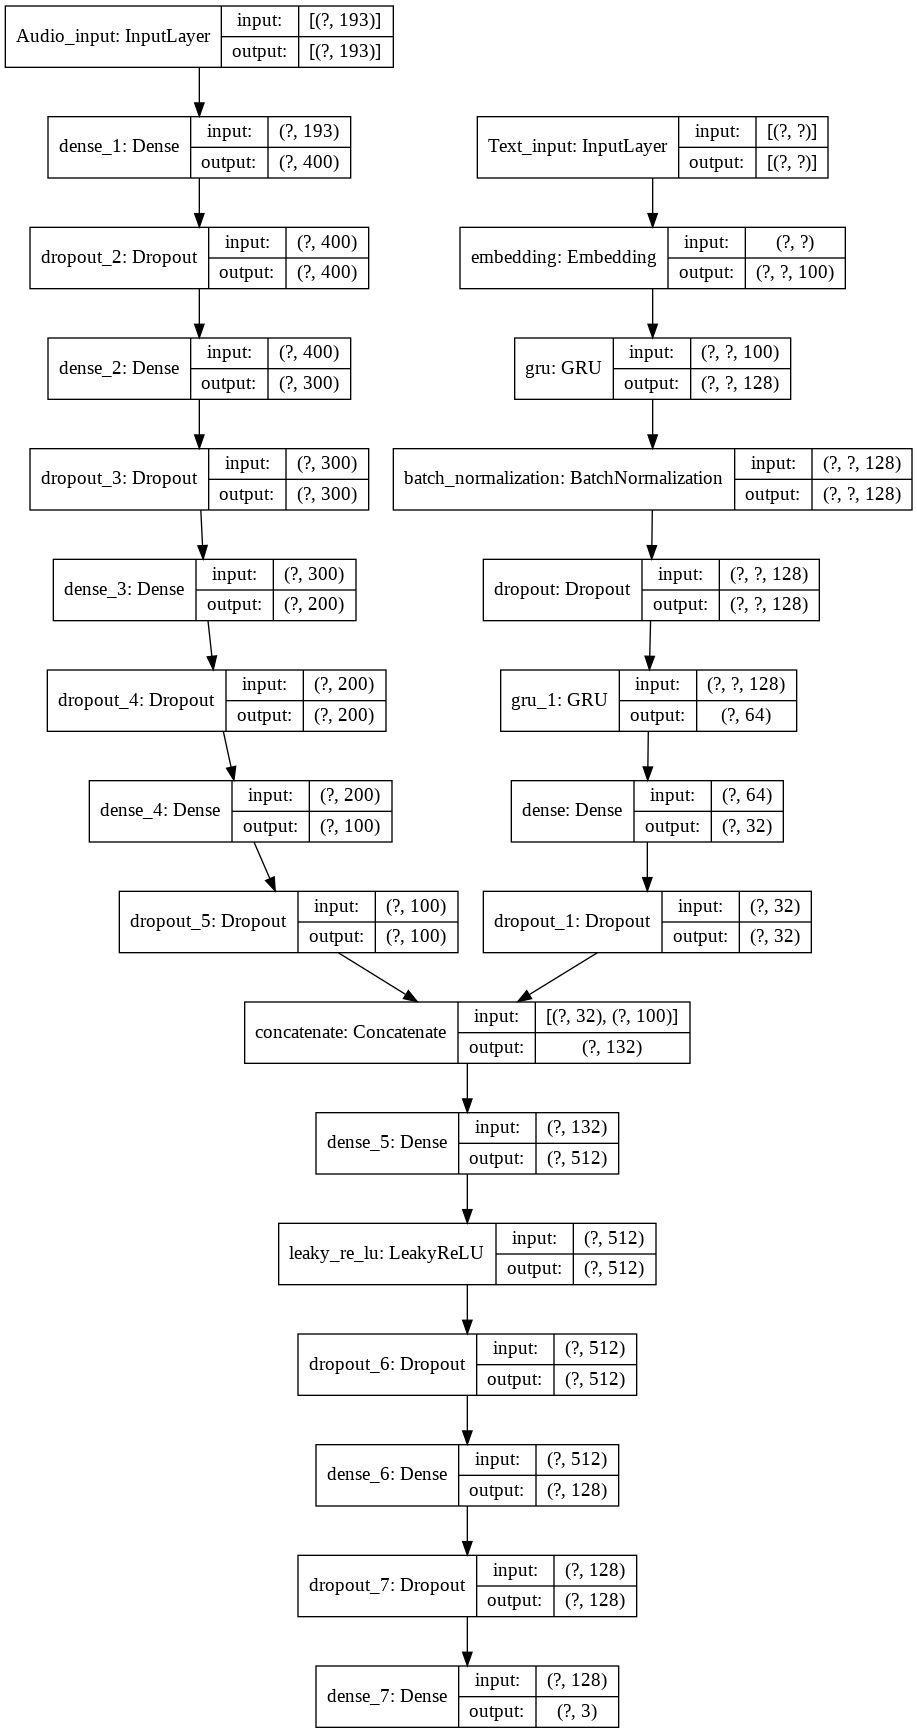

In [14]:
reg_val = 0.0001

combine = layers.concatenate([x,layer])
y = Dense(512,kernel_regularizer = regularizers.l2(reg_val),bias_regularizer = regularizers.l2(reg_val) )(combine)
y = layers.LeakyReLU(alpha=0.1)(y)
y = Dropout(0.2)(y)
y = Dense(128,activation ='relu')(y)
y = Dropout(0.2)(y)



predictions = Dense(3,activation ='softmax')(y) 

combinedModel = Model(inputs=[posts_input,input1 ], outputs=[predictions])
combinedModel.summary()
plot_model(combinedModel, to_file='combined_model.png',show_shapes=True, show_layer_names=True)





In [15]:
callbacks_list = [
                ModelCheckpoint(filepath='model_multi-feature.h5', monitor='val_loss',
                        save_best_only=True,)]
combinedModel.compile(optimizer = 'rmsprop',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

epochs = 50
batch_size = 64

hist = combinedModel.fit([x_train_text,x_train_audio],  y_train,
                                  epochs = epochs, batch_size = batch_size,
                        callbacks = callbacks_list,
               validation_data = ([x_val_text,x_val_audio],  y_val)).history

Epoch 1/50
125/125 [==============================] - 16s 128ms/step - loss: 1.3166 - accuracy: 0.4255 - val_loss: 1.0963 - val_accuracy: 0.4725
Epoch 2/50
125/125 [==============================] - 15s 123ms/step - loss: 1.0870 - accuracy: 0.4630 - val_loss: 1.0956 - val_accuracy: 0.4700
Epoch 3/50
125/125 [==============================] - 15s 124ms/step - loss: 1.0730 - accuracy: 0.4683 - val_loss: 1.0673 - val_accuracy: 0.4720
Epoch 4/50
125/125 [==============================] - 15s 124ms/step - loss: 1.0684 - accuracy: 0.4701 - val_loss: 1.0660 - val_accuracy: 0.4785
Epoch 5/50
125/125 [==============================] - 16s 124ms/step - loss: 1.0550 - accuracy: 0.4782 - val_loss: 1.0492 - val_accuracy: 0.4930
Epoch 6/50
125/125 [==============================] - 15s 124ms/step - loss: 1.0422 - accuracy: 0.4867 - val_loss: 1.0602 - val_accuracy: 0.4910
Epoch 7/50
125/125 [==============================] - 15s 124ms/step - loss: 1.0334 - accuracy: 0.4935 - val_loss: 1.0591 - val_ac

In [0]:
import h5py
train_acc = hist['accuracy']
val_acc = hist['val_accuracy']
train_loss = hist['loss']
val_loss = hist['val_loss']

with h5py.File('learningrate_plot.hd5', 'w') as hf:
    hf.create_dataset('train_acc', data = train_acc)
    hf.create_dataset('val_acc', data = val_acc)
    hf.create_dataset('train_loss', data = train_loss)
    hf.create_dataset('val_loss', data = val_loss)
    


In [17]:
model1 = load_model('model_multi-feature.h5')
pred = model1.predict([x_test_text,x_test_audio])
label_predict = np.argmax(pred,axis=1 )
print(set(label_predict))

label_acc = accuracy_score(label_predict, y_test)

print("ACCURACY : ",label_acc)

{1, 2}
ACCURACY :  0.5153256704980843


train_acc
train_loss
val_acc
val_loss


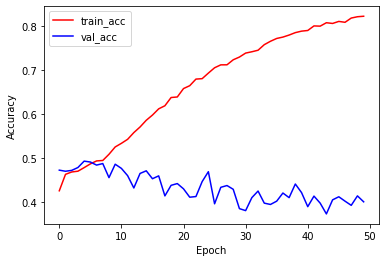

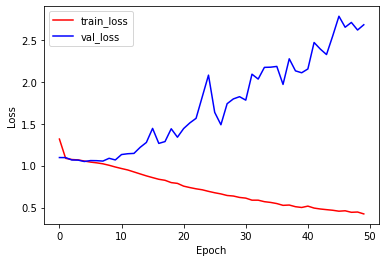

In [18]:
with h5py.File('learningrate_plot.hd5', 'r') as hf:
    for i in hf.keys():
        print(i)
    
    train_acc = hf['train_acc'][:] 
    val_acc = hf['val_acc'][:] 
    train_loss = hf['train_loss'][:] 
    val_loss = hf['val_loss'][:] 


epochs = 50

plt.figure()
plt.plot(np.arange(epochs),train_acc,'r',label = "train_acc")
plt.plot(np.arange(epochs),val_acc,'b',label = "val_acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure()
plt.plot(np.arange(epochs),train_loss,'r',label = "train_loss")
plt.plot(np.arange(epochs),val_loss,'b',label = "val_loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

[[   0  108  413]
 [   0  243  590]
 [   0  154 1102]]


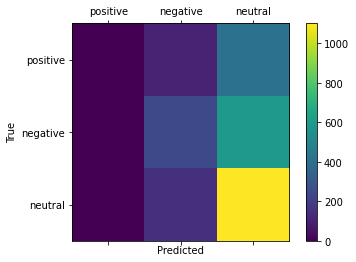

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

label7 = ['sadness', 'surprise','neutral','joy', 'anger','disgust','fear']
labels = ['positive', 'negative', 'neutral']
cm = confusion_matrix(y_test, label_predict)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()